R environment

In [ ]:
suppressPackageStartupMessages({
    library(reticulate)
    library(ggplot2)
    library(scater)
    library(Seurat)
    library(dplyr)
    library(tidyr)
    library(purrr)
    library(rlog)
    library(tibble)
    library(stringr)
    library(dittoSeq)
    library(patchwork)
    library(HGNChelper)
    library(future)
    plan("multiprocess", workers = 12)
    options(future.globals.maxSize = 1000 * 1024^5)
    options(stringsAsFactors = FALSE)
    set.seed(123)
})

Warning message:
“Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”


In [ ]:
reference <- readRDS('data/core_GBmap.rds')

### Load query

In [ ]:
reference.list <- readRDS('data/core_GBmap_seuratobj_list.rds')
gbm <- reference.list[['Ruiz2021']]
gbm

An object of class Seurat 
27102 features across 39355 samples within 1 assay 
Active assay: RNA (27102 features, 0 variable features)

In [ ]:
rm(reference.list)

In [ ]:
gbm <- NormalizeData(gbm)%>%FindVariableFeatures()%>%ScaleData()%>%RunPCA()

Centering and scaling data matrix

PC_ 1 
Positive:  NRG3, STXBP5L, FAM155A, CACNA1C, KALRN, ATRNL1, AGBL4, FGF14, PTPRN2, CSMD1 
	   DCLK1, GRIK2, PLCB1, SYN2, CNTN1, NTRK3, FRMPD4, LRFN5, RIMS2, SLC4A10 
	   SNTG1, CADPS, SYT1, GRIA1, GRM5, CACNA1B, ATP2B2, KCNQ5, RALYL, GABBR2 
Negative:  DOCK8, APBB1IP, TBXAS1, SPP1, FYB1, SLCO2B1, SLC11A1, PIK3R5, AC074327.1, GLDN 
	   INPP5D, TLR2, ARHGAP15, LRMDA, PTPRC, LYN, MSR1, CPM, ADAM28, RBM47 
	   SRGN, LPCAT2, CSF2RA, ACSL1, SAMSN1, FLI1, MERTK, IRAK3, IKZF1, CTSB 
PC_ 2 
Positive:  RFX4, PRRX1, GLIS3, BMPR1B, PALLD, AQP4, GFAP, LIFR, ALDH1L1, FAM189A2 
	   CNN3, ACSS3, PARD3, LINC01088, DCLK2, TNC, YAP1, CD44, LRIG1, CLU 
	   SYTL4, PTPRZ1, PMP2, AC073941.1, PLSCR4, RGMA, AHCYL1, NKAIN3, LINC00299, PAMR1 
Negative:  KCNQ3, FRMD4A, DLGAP2, SYT1, GABRG3, LRFN5, FRMPD4, HCN1, KHDRBS2, CACNA1B 
	   CABP1, CCSER1, KCNC2, MTUS2, CHD5, GALNT17, MYT1L, RBFOX3, ZNF385B, VSNL1 
	   RYR2, ATP8A2, CELF4, SYN2, GRIN1, GABRB2, RIMS2, FMN1, GABBR2, I

### Reference mapping

In [ ]:
reference <- FindVariableFeatures(reference, selection.method = "vst", nfeatures = 2000)
reference <- ScaleData(reference, features = VariableFeatures(object = reference), verbose = FALSE)
reference <- RunPCA(reference, features = VariableFeatures(object = reference), verbose = FALSE)

In [ ]:
anchors <- FindTransferAnchors(
  reference = reference,
  query = gbm,
  features = rownames(reference[["RNA"]]),
  normalization.method = "LogNormalize",
  reference.reduction = "pca",
  dims = 1:50
)

Warning message:
“201 features of the features specified were not present in both the reference query assays. 
Continuing with remaining 4799 features.”
Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 5574 anchors

Filtering anchors

	Retained 1300 anchors



`Map Query` functions run separately

In [ ]:
gbm <- TransferData(
  anchorset = anchors, 
  reference = reference,
  query = gbm,
  refdata = list(
      high_hierarchy = 'annotation_level_3',
      low_hierarchy = 'annotation_level_4'
  ),
)

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorehigh_hierarchy_ to predictionscorehighhierarchy_”
Predicting cell labels

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorelow_hierarchy_ to predictionscorelowhierarchy_”


In [ ]:
gbm <- IntegrateEmbeddings(
  anchorset = anchors,
  reference = reference,
  query = gbm, 
  new.reduction.name = "ref.pca"
)

Integrating dataset 2 with reference dataset

Finding integration vectors

Integrating data

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-1’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to refpca_”


### UMAP embbeding projection

In [ ]:
gbm <- ProjectUMAP(
  query = gbm, 
  query.reduction = "ref.pca", 
  reference = reference, 
  reference.reduction = "pca", 
  reduction.model = "umap"
)

Computing nearest neighbors

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Running UMAP projection

10:45:24 Using PCG for random number generation

10:45:24 Read 39355 rows and found  numeric columns

10:45:24 Processing block 1 of 1

10:45:24 Commencing smooth kNN distance calibration using 12 threads

10:45:24 Initializing by weighted average of neighbor coordinates using 12 threads

10:45:24 Commencing optimization for 167 epochs, with 787100 positive edges

10:46:29 Finished

Warning message:
“No assay specified, setting assay as RNA by default.”


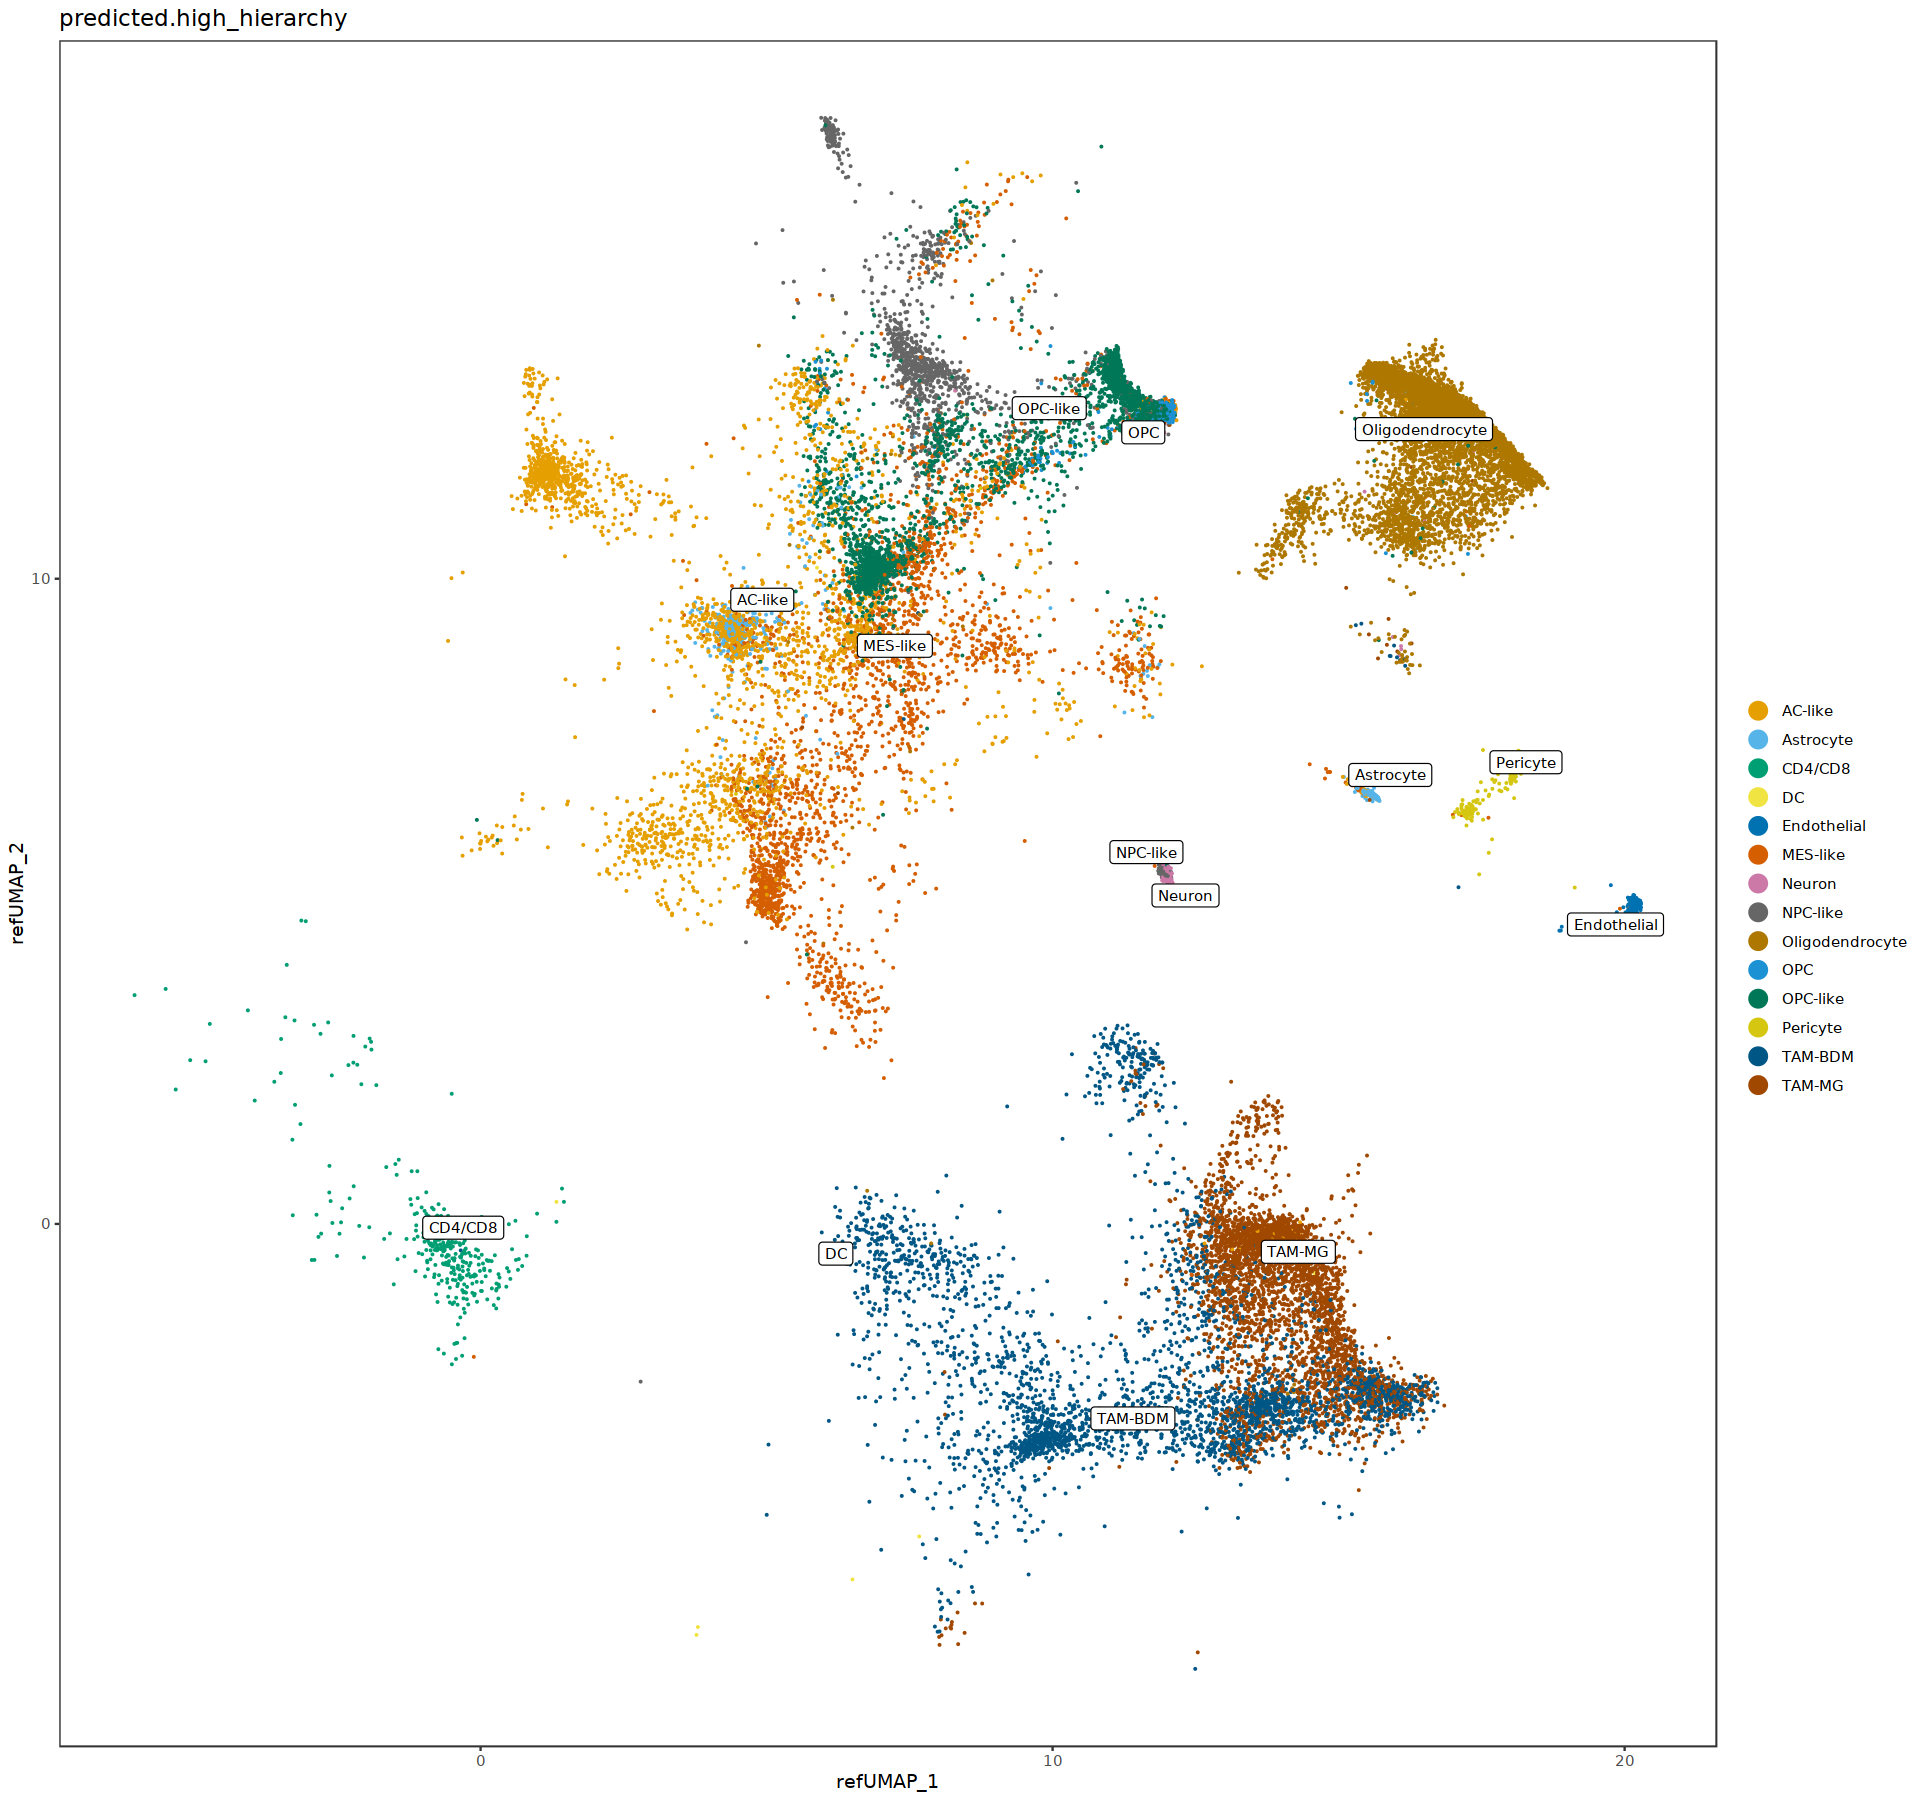

In [ ]:
dittoDimPlot(gbm, 
             reduction.use = "ref.umap", var = "predicted.high_hierarchy", 
             do.label = T, labels.size = 3, size = 0.5)

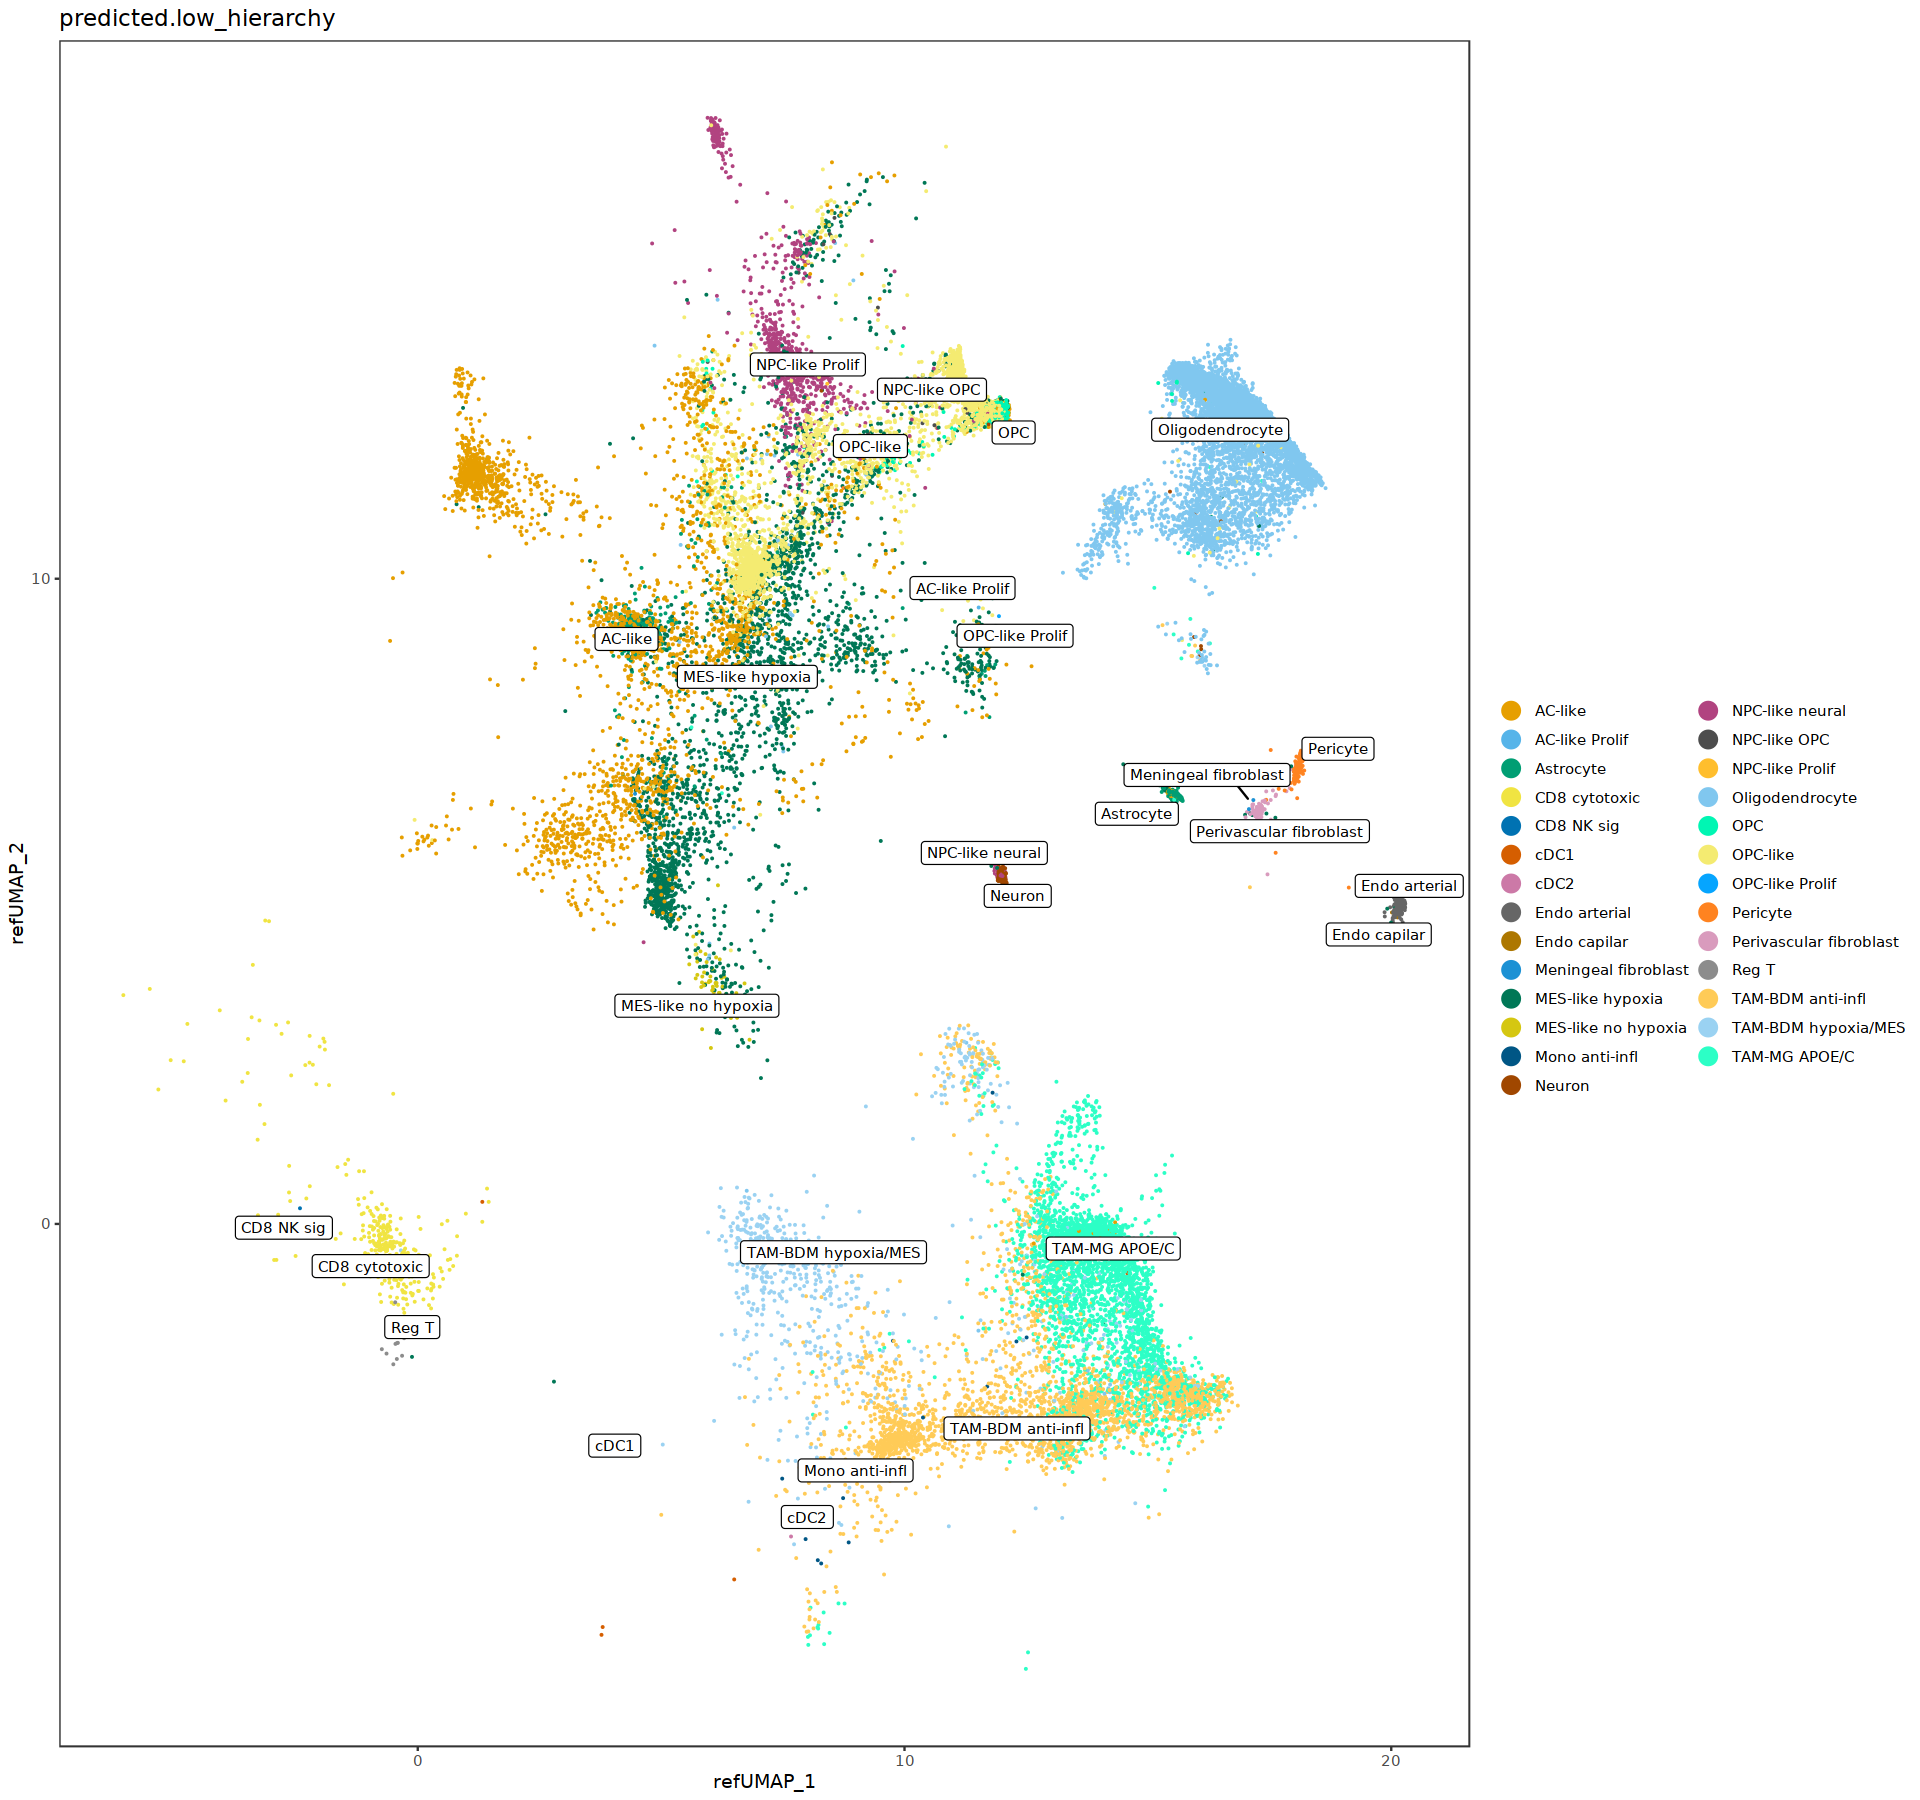

In [ ]:
dittoDimPlot(gbm, 
             reduction.use = "ref.umap", var = "predicted.low_hierarchy", 
             do.label = T, labels.size = 3, size = 0.5)

In [ ]:
Idents(gbm) <- gbm@meta.data$predicted.low_hierarchy
markers <- FindAllMarkers(gbm, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster AC-like

Calculating cluster AC-like Prolif

Calculating cluster MES-like hypoxia

Calculating cluster MES-like no hypoxia

Calculating cluster OPC-like

Calculating cluster OPC-like Prolif

Calculating cluster NPC-like OPC

Calculating cluster NPC-like neural

Calculating cluster NPC-like Prolif

Calculating cluster Astrocyte

Calculating cluster Oligodendrocyte

Calculating cluster OPC

Calculating cluster Neuron

Calculating cluster Mono anti-infl

Calculating cluster TAM-BDM hypoxia/MES

Calculating cluster TAM-BDM anti-infl

Calculating cluster TAM-MG APOE/C

Calculating cluster cDC1

Calculating cluster cDC2

Calculating cluster CD8 cytotoxic

Calculating cluster CD8 NK sig

Calculating cluster Reg T

Calculating cluster Endo capilar

Calculating cluster Endo arterial

Calculating cluster Pericyte

Calculating cluster Perivascular fibroblast

Calculating cluster Meningeal fibroblast



Warning message in DoHeatmap(subset(gbm, downsample = 200), features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: THBS2, RORA, INSR, IKZF2, PHACTR2, AL138720.1, RASGRP1, PARP8, AKNA, CCDC88C, WDFY4, CCND3, CLNK, PLXDC2, FCHO2, NKAIN2, PEX5L, UNC5C, C10orf90, MBP, SLC24A2, CTNNA3, ST18, RNF220, KCNQ1OT1, BNIP3L”


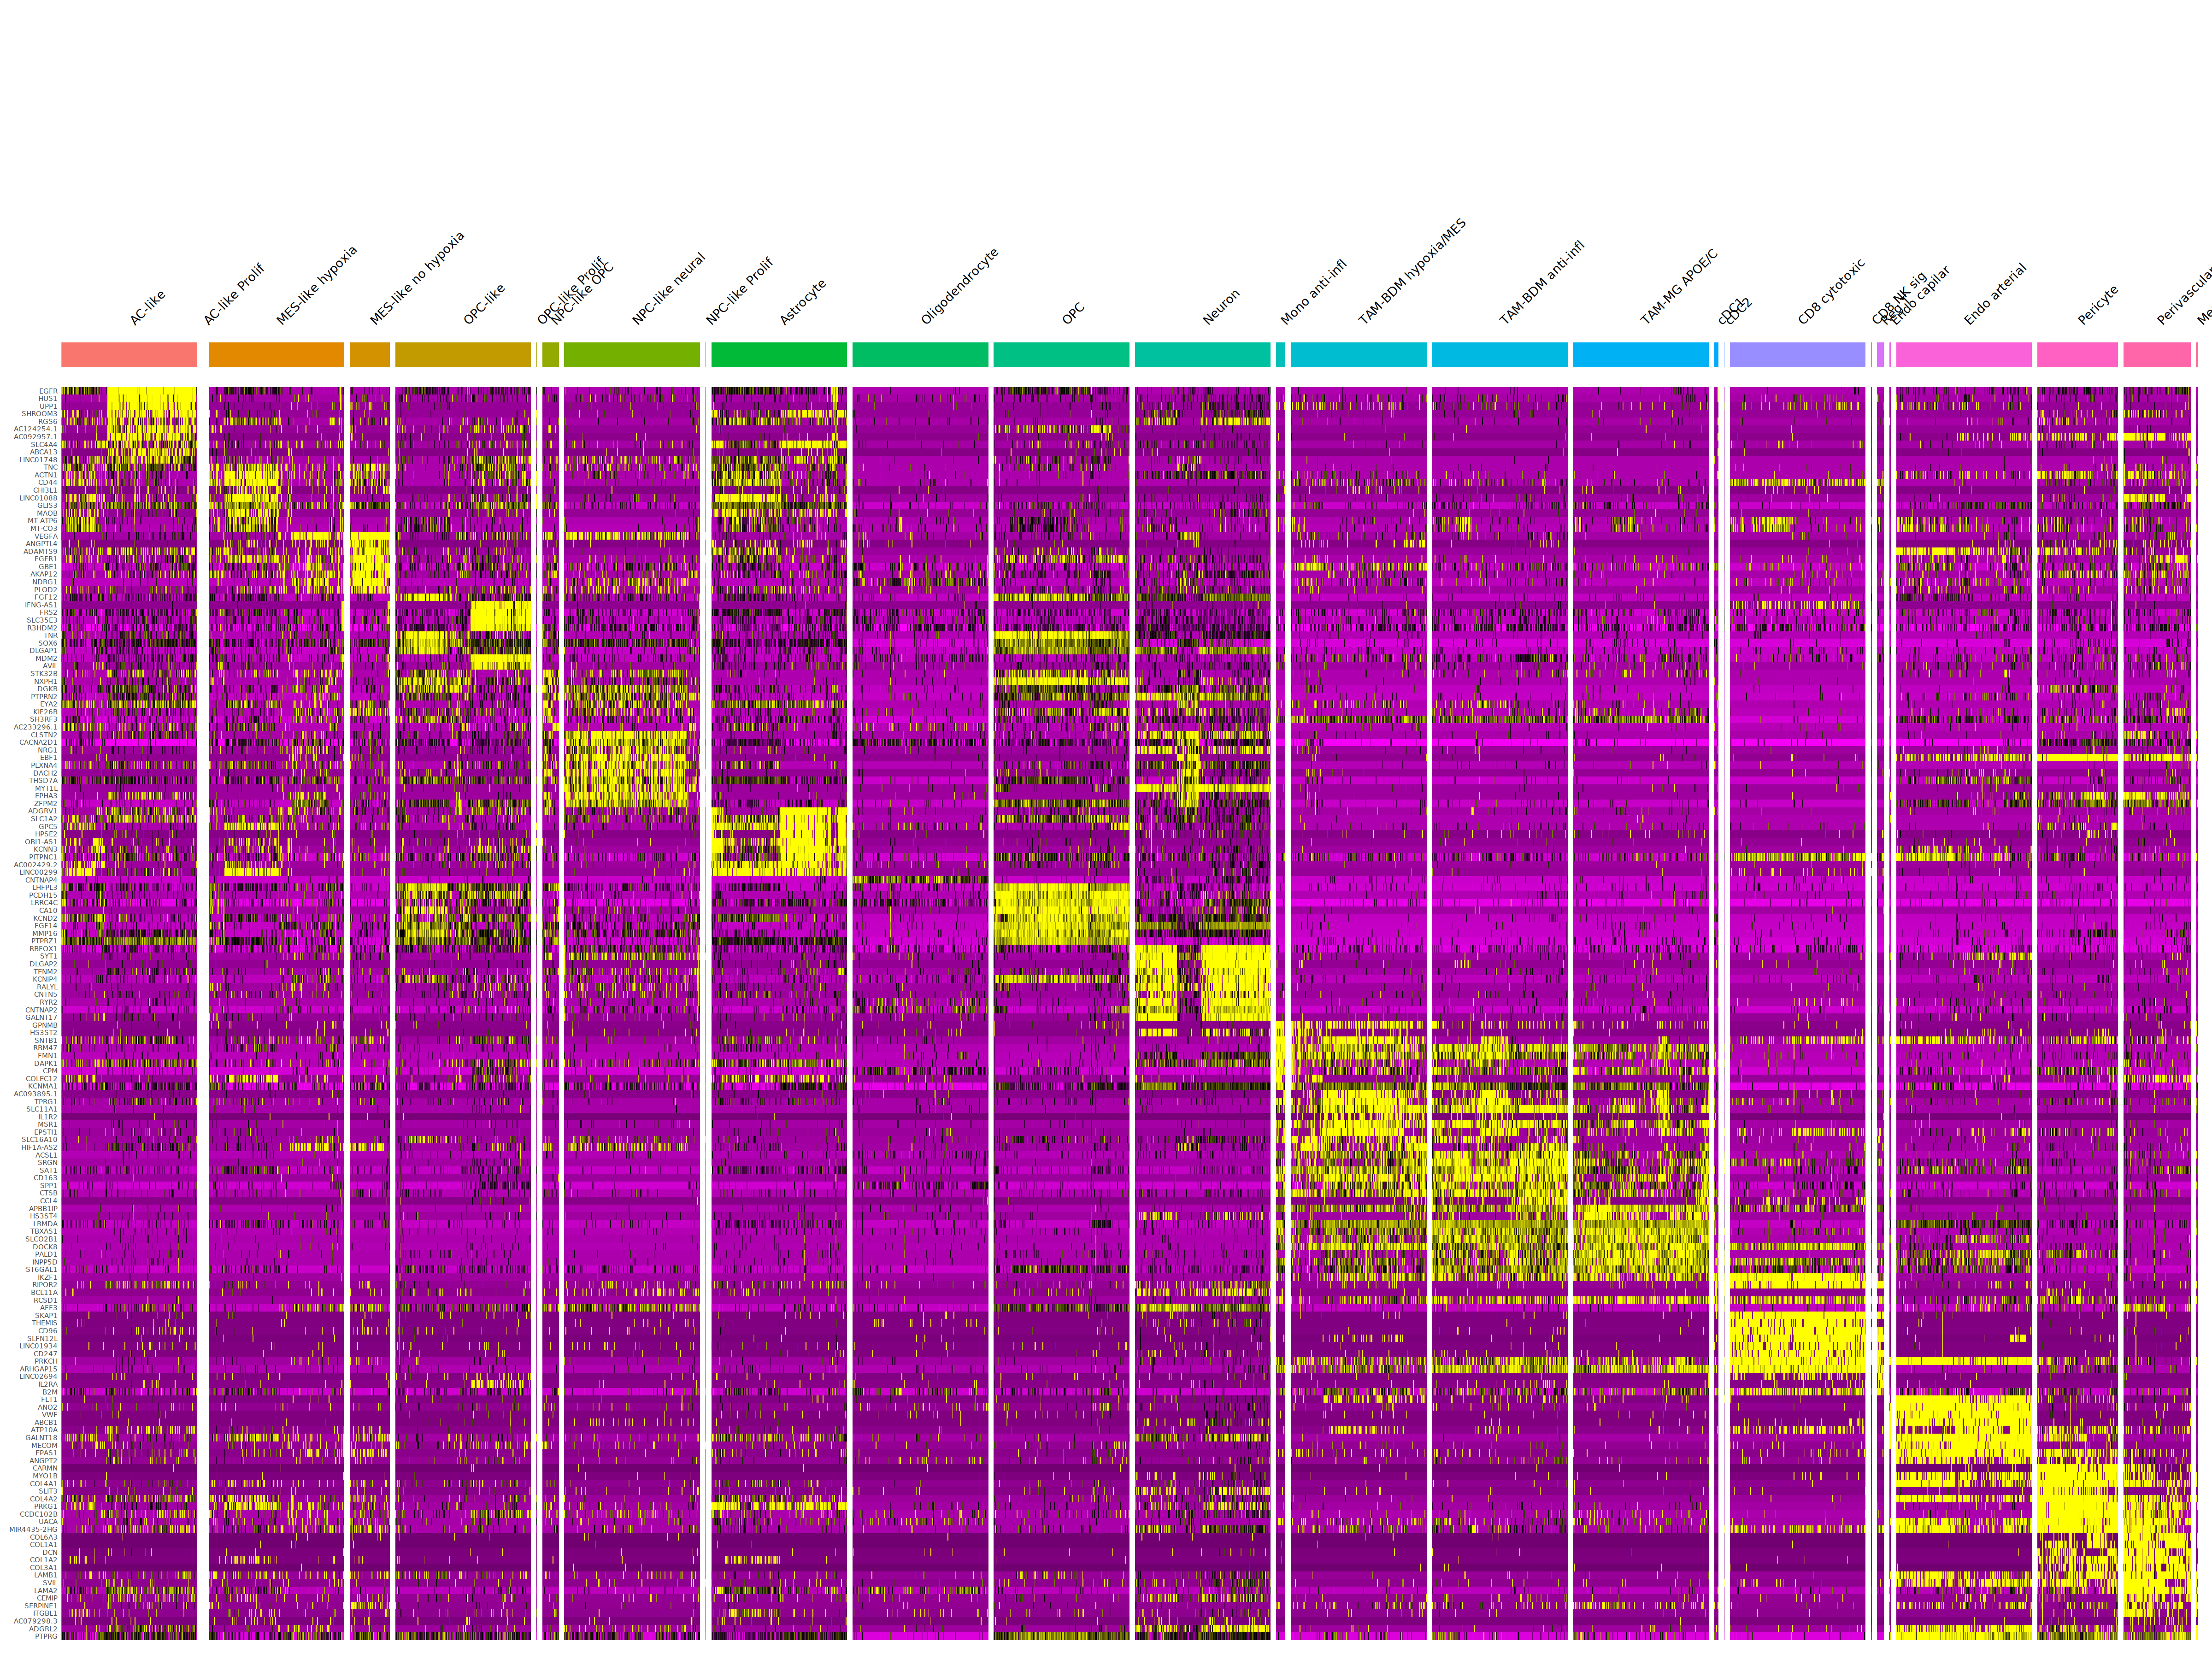

In [ ]:
markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
options(repr.plot.height = 30, repr.plot.width = 40)
DoHeatmap(subset(gbm, downsample = 200), features = top10$gene) + NoLegend()

In [ ]:
saveRDS(gbm, 'data/mapped_Ruiz2021_to_core_GBmap.rds')